# StackedGAN

In [1]:
import os
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense,Reshape, Conv2D, Dropout,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,Activation,Embedding,multiply
from tensorflow.keras.layers import Conv2DTranspose,Flatten, LeakyReLU, concatenate
from tensorflow.keras.datasets import mnist
from PIL import Image
from matplotlib.pyplot import imshow

In [2]:
#temp
import tensorflow.keras.backend as K

## Load the data

In [3]:
from tensorflow.keras.datasets import mnist
(xtr,ytr), (xtest,ytest) = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255
xtest = xtest.reshape((-1,28,28,1)).astype('float32')/255
ytr = to_categorical(ytr)
ytest = to_categorical(ytest)

### Create a dataViewer

In [4]:
%matplotlib inline
from GAN.utils import dataViewer

In [5]:
def viewMnist(mtr):
    '''Return from a numpy array an Image'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    imshow(mtr,cmap='gray')
def saveMnist(mtr,path):
    '''Save as file the numpy array'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    Image.fromarray(mtr).resize((280,280)).save(path)

In [6]:
vwr = dataViewer(functionView=viewMnist,functionSave=saveMnist,path="D:/Project/DeepLearning/GAN/StackedGAN/output/")

### Create a stackedGAN

In [7]:
def build_encoder():
    feature1_dim=256
    num_labels=10
    inputs = [Input(shape=(28,28,1),name='ImageInput'),Input(shape=(feature1_dim,), name='feature1_input')]
    kernel_size = 3
    filters = 64
    x, feature1 = inputs
    y = Conv2D(filters=filters,kernel_size=kernel_size,padding='same',activation='relu')(x)
    y = MaxPooling2D()(y)
    y = Conv2D(filters=filters,kernel_size=kernel_size,padding='same',activation='relu')(y)
    y = MaxPooling2D()(y)
    y = Flatten()(y)
    feature1_output = Dense(feature1_dim, activation='relu')(y)
    enc0 = Model(inputs=x, outputs=feature1_output, name="encoder0")
    
    
    y = Dense(num_labels)(feature1)
    labels = Activation('softmax')(y)
    enc1 = Model(inputs=feature1, outputs=labels, name="encoder1")
    # return both enc0 and enc1
    return enc0, enc1


encoder0, encoder1 = build_encoder()
encoder0.summary()
encoder1.summary()

Model: "encoder0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803

In [8]:
from GAN.GAN.AttributeGAN import subStackedGAN

#### Create GAN0

In [9]:
def buildGen0():
    activation='sigmoid'
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    inputs = [Input(shape=(50,),name="z0"),Input(shape=(256,),name="feature1Inpt")]
    
    x = concatenate(inputs, axis=1)
    x = Dense(7 * 7 * layer_filters[0])(x)
    x = Reshape((7, 7, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,strides=strides,padding='same')(x)
        x = Activation('sigmoid')(x)
    return Model(inputs, x, name='generator0')


generator0 = buildGen0()
generator0.summary()

Model: "generator0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z0 (InputLayer)                 [(None, 50)]         0                                            
__________________________________________________________________________________________________
feature1Inpt (InputLayer)       [(None, 256)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 306)          0           z0[0][0]                         
                                                                 feature1Inpt[0][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         1925504     concatenate[0][0]       

In [10]:

def discriminator0():
    """Discriminator0;
    input: generrator0 outputs"""
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    inputs = Input(shape=(28,28,1), name='discriminator0_input')
    x = inputs
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(1)(x)
    outputs = Activation('sigmoid')(outputs)
    z0_recon =  Dense(50)(x)
    z0_recon = Activation('tanh', name='z0')(z0_recon)
    outputs = [outputs, z0_recon]

    return Model(inputs, outputs, name='discriminator0')

discriminator0 = discriminator0()
discriminator0.summary()

Model: "discriminator0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator0_input (InputLaye [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 1)    0           discriminator0_input[0][0]       
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   832         leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_2[0][0]                   
_____________________________________________________________________________________

In [11]:
gan0 = subStackedGAN(generator=generator0,discriminator=discriminator0,encoder=encoder0,
                     DiscrOptimizer=RMSprop(lr=1e-4, decay=3e-8),GanOptimizer=RMSprop(lr=2e-4, decay=6e-8),
                     dis_loss_weights=[1.0, 10.0],adv_loss_weights=[1.0, 10.0, 1.0],
                     dis_loss=['binary_crossentropy', 'mse'],adv_loss=['binary_crossentropy', 'mse', 'mse'])

#### Create GAN1


In [12]:
def buildGen1():
    inputs = [Input(shape=(50,),name="z1"),Input(shape=(10,),name="label")]
    x = concatenate(inputs, axis=1)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    fake_feature1 = Dense(256, activation='relu',name="outputGen1")(x)
    gen1 = Model(inputs, fake_feature1, name='generator1')
    return gen1


generator1 = buildGen1()
generator1.summary()

Model: "generator1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z1 (InputLayer)                 [(None, 50)]         0                                            
__________________________________________________________________________________________________
label (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 60)           0           z1[0][0]                         
                                                                 label[0][0]                      
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          31232       concatenate_1[0][0]     

In [13]:
def discriminator1():
    inputs = Input(shape=(256,),name="feature1")
    x = Dense(256, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    f1_source = Dense(1)(x)
    f1_source = Activation('sigmoid', name='feature1_source')(f1_source)
    z1_recon = Dense(50)(x) 
    z1_recon = Activation('tanh', name='z1_estimation')(z1_recon)
    
    discriminator_outputs = [f1_source, z1_recon]
    dis1 = Model(inputs, discriminator_outputs, name='discriminator1')
    return dis1

discriminator1 = discriminator1()
discriminator1.summary()

Model: "discriminator1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature1 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 256)          65792       feature1[0][0]                   
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          65792       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            257         dense_8[0][0]                    
_____________________________________________________________________________________

In [14]:
gan1 = subStackedGAN(generator=generator1,discriminator=discriminator1,encoder=encoder1,
                     DiscrOptimizer=RMSprop(lr=1e-4, decay=3e-8),GanOptimizer=RMSprop(lr=2e-4, decay=6e-8),
                     dis_loss_weights=[1.0, 10.0],adv_loss_weights=[1.0, 10.0, 1.0],
                     dis_loss=['binary_crossentropy', 'mse'],adv_loss=['binary_crossentropy', 'mse', 'mse'])

#### Create the stacked

In [15]:
from GAN.GAN.AttributeGAN import StackedGAN

In [16]:
StGAN = StackedGAN(gan0,gan1)
StGAN.generateBatchEval()

## Train the encoder

In [17]:
StGAN.trainencoder(xtr=xtr,ytr=ytr,epochs=10,batchsize=1024,validation_data=(xtest,ytest))

Encoder Trainig
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.5154 - accuracy: 0.8589 - val_loss: 0.1377 - val_accuracy: 0.9596
Epoch 2/10
60000/60000 [==============================] - 5s 82us/sample - loss: 0.1050 - accuracy: 0.9689 - val_loss: 0.0647 - val_accuracy: 0.9798
Epoch 3/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0639 - accuracy: 0.9810 - val_loss: 0.0487 - val_accuracy: 0.9850
Epoch 4/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0492 - accuracy: 0.9853 - val_loss: 0.0413 - val_accuracy: 0.9850
Epoch 5/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0405 - accuracy: 0.9875 - val_loss: 0.0342 - val_accuracy: 0.9883
Epoch 6/10
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.0319 - val_accuracy: 0.9879
Epoch 7/10
60000/60000 [===============

In [18]:
StGAN.train(x_train=[xtr,ytr],epoch=30,batch_size=1024,evalStep=1,pathSave=None,dataViewer=vwr)

Epoch 1/30
117/117 [==============================] - 147s 1s/step
{'Gan0': {'loss': 2.5754649639129634, 'activation_9_loss': 0.061119561264705316, 'z0_loss': 0.25143454051934755, 'activation_9_accuracy': 0.9979467147435886, 'z0_accuracy': 0.020332532051282017}, 'Gan1': {'loss': 0, 'feature1_source_loss': 0, 'z1_estimation_loss': 0, 'feature1_source_accuracy': 0, 'z1_estimation_accuracy': 0}}
{'Gan0': {'loss': 3.006206072293796, 'discriminator0_loss': 0.08027728326105252, 'discriminator0_1_loss': 0.2512132250345671, 'encoder0_loss': 0.41379653465034627, 'discriminator0_accuracy': 0.943175747863247, 'discriminator0_1_accuracy': 0.022335737179487142, 'encoder0_accuracy': 0.5721487713675213}, 'Gan1': {'loss': 0, 'discriminator1_loss': 0, 'discriminator1_1_loss': 0, 'encoder1_loss': 0, 'discriminator1_accuracy': 0, 'discriminator1_1_accuracy': 0, 'encoder1_accuracy': 0}}
Epoch 2/30
117/117 [==============================] - 145s 1s/step
{'Gan0': {'loss': 2.50703418152964, 'activation_9_los

117/117 [==============================] - 153s 1s/step
{'Gan0': {'loss': 2.9045038019490037, 'activation_9_loss': 0.5592795508539572, 'z0_loss': 0.23452242533875325, 'activation_9_accuracy': 0.6956881009615387, 'z0_accuracy': 0.06426949786324787}, 'Gan1': {'loss': 0, 'feature1_source_loss': 0, 'z1_estimation_loss': 0, 'feature1_source_accuracy': 0, 'z1_estimation_accuracy': 0}}
{'Gan0': {'loss': 2.727297548554903, 'discriminator0_loss': 0.2809697040635296, 'discriminator0_1_loss': 0.22644711190309277, 'encoder0_loss': 0.18185672571516442, 'discriminator0_accuracy': 0.9225928151709399, 'discriminator0_1_accuracy': 0.08465211004273498, 'encoder0_accuracy': 0.678952991452991}, 'Gan1': {'loss': 0, 'discriminator1_loss': 0, 'discriminator1_1_loss': 0, 'encoder1_loss': 0, 'discriminator1_accuracy': 0, 'discriminator1_1_accuracy': 0, 'encoder1_accuracy': 0}}
Epoch 12/30
117/117 [==============================] - 151s 1s/step
{'Gan0': {'loss': 2.8866503401699224, 'activation_9_loss': 0.552248

117/117 [==============================] - 148s 1s/step
{'Gan0': {'loss': 2.7883905182536854, 'activation_9_loss': 0.5661210680109822, 'z0_loss': 0.2222269461450414, 'activation_9_accuracy': 0.6860727163461535, 'z0_accuracy': 0.10214676816239307}, 'Gan1': {'loss': 0, 'feature1_source_loss': 0, 'z1_estimation_loss': 0, 'feature1_source_accuracy': 0, 'z1_estimation_accuracy': 0}}
{'Gan0': {'loss': 2.4400583271287446, 'discriminator0_loss': 0.38205365671051883, 'discriminator0_1_loss': 0.18824475939966676, 'encoder0_loss': 0.17555707311018912, 'discriminator0_accuracy': 0.8454026442307696, 'discriminator0_1_accuracy': 0.1692875267094016, 'encoder0_accuracy': 0.6794204059829059}, 'Gan1': {'loss': 0, 'discriminator1_loss': 0, 'discriminator1_1_loss': 0, 'encoder1_loss': 0, 'discriminator1_accuracy': 0, 'discriminator1_1_accuracy': 0, 'encoder1_accuracy': 0}}
Epoch 22/30
117/117 [==============================] - 155s 1s/step
{'Gan0': {'loss': 2.783001966965504, 'activation_9_loss': 0.564104

In [19]:
from GAN.utils import createGif
createGif(pathOutput="D:/Project/DeepLearning/GAN/StackedGAN/output/",modelName="StackedGAN",outputSize=(4,4),plt_vs_Image=1)

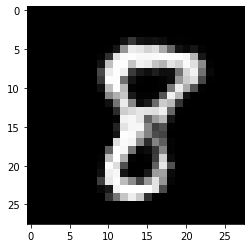

In [20]:
StGAN.GenerateOutputs(batchsize=1,xtest=None,returnArray=False,dataViewer=vwr,save=False,view=True,epoch=30)